In [2]:
import warnings
warnings.filterwarnings("ignore")

# 1. Данные (пример на SBER)

In [3]:
import pandas as pd
import numpy as np

## 1.1. Импорт данных

In [4]:
df = pd.read_csv('/kaggle/input/moexsample/train.csv')

## 1.2. Предобработка данных

In [5]:
df['datetime'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
df = df[df['TICKER'] == 'SBER']
df = df.drop(['TICKER','TIME','DATE','PER'], axis=1)
df.set_index('datetime', inplace=True)
df

,OPEN,HIGH,LOW,CLOSE,VOL
datetime,,,,,
2024-02-01 10:00:00,276.07,276.20,276.03,276.09,107540
2024-02-01 10:01:00,276.15,276.17,275.93,275.97,76600
2024-02-01 10:02:00,275.96,276.09,275.96,276.02,27280
2024-02-01 10:03:00,276.06,276.20,276.06,276.11,62340
2024-02-01 10:04:00,276.12,276.19,276.11,276.12,35690
...,...,...,...,...,...
2024-05-08 23:45:00,311.21,311.22,311.19,311.20,5410
2024-05-08 23:46:00,311.20,311.20,311.17,311.17,4040
2024-05-08 23:47:00,311.19,311.19,311.13,311.13,16310


## 1.3. Указываем диапозон семплирования

In [6]:
df_60T=df.resample('60T').sum()

## 1.4. Визуализация

<Axes: xlabel='datetime'>

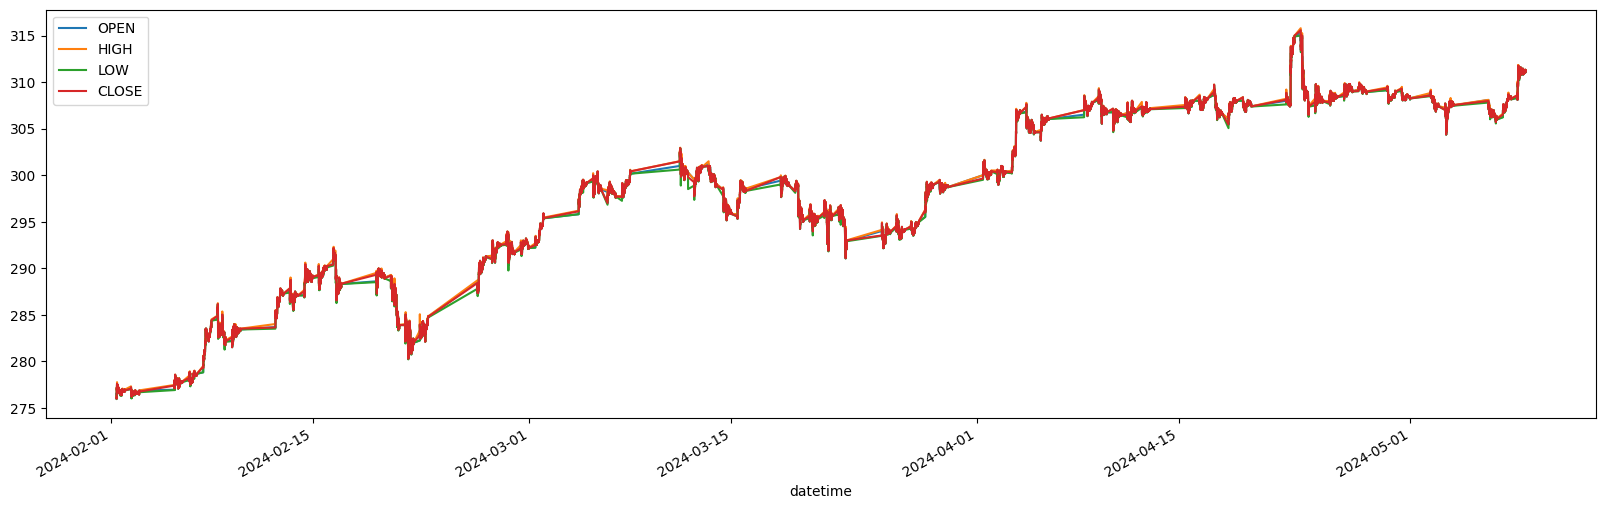

In [7]:
df.drop('VOL',axis=1).plot(figsize=(20,6))

# 2. Модель

In [8]:
!pip install --quiet skforecast

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingRegressor

## 2.1. Сплит данных

In [9]:
def split_time_data(df):
    end_train = '2024-04-08'
    data_train = df.loc[:end_train, :].copy()
    data_test  = df.loc[end_train:, :].copy()
    print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
    print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
    
    return data_train, data_test

In [10]:
data_train, data_test = split_time_data(df_60T)

Train dates      : 2024-02-01 10:00:00 --- 2024-04-08 23:00:00  (n=1622)
Test dates       : 2024-04-08 00:00:00 --- 2024-05-08 23:00:00  (n=744)


## 2.2. Обучение модели

In [11]:
items = list(df[['OPEN','HIGH','LOW','CLOSE',]].columns)
forecaster_ms = ForecasterAutoregMultiSeries(
    regressor=HistGradientBoostingRegressor(),
    lags=24,
    transformer_series=StandardScaler()
)
forecaster_ms.fit(data_train[items])

# 3. Подсчет качества

In [12]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [13]:
predict=forecaster_ms.predict(steps=len(data_test))
mean_absolute_percentage_error(data_test['CLOSE'],predict['CLOSE'])

45.95071454596351